In [2]:
# Instantiate the VGG16 convolutional base
from keras.applications import VGG16

conv_base=VGG16(weights='imagenet', include_top=False, input_shape=(150,150,3))
# weights: specify which weight checkpoint to initialize the model from
# include_top: include or not the densely-connected classifier on top of the network
# input_shape: the shape of image tensors that will feed to the network

conv_base.summary()

58892288/58889256 [==============================] - 66s 1us/step
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_poo

In [3]:
# Extract features using the pretrained convolutional base
import os
import numpy as np
from keras.preprocessing.image import ImageDataGenerator

base_dir='/Users/think/Downloads/cats_and_dogs_small'
train_dir=os.path.join(base_dir,'train')
validation_dir=os.path.join(base_dir, 'validation')
test_dir=os.path.join(base_dir, 'test')

datagen=ImageDataGenerator(rescale=1./255)
batch_size=20

def extract_features(directory, sample_count):
    features=np.zeros(shape=(sample_count, 4, 4, 512))
    labels=np.zeros(shape=(sample_count))
    generator=datagen.flow_from_directory(directory,target_size=(150,150),batch_size=batch_size,class_mode='binary')
    i=0
    for inputs_batch, labels_batch in generator:
        features_batch=conv_base.predict(inputs_batch)
        features[i*batch_size:(i+1)*batch_size]=features_batch
        labels[i*batch_size:(i+1)*batch_size]=labels_batch
        i+=1
        if i*batch_size>=sample_count:
            break
    return features, labels

train_features, train_labels=extract_features(train_dir, 2000)
validation_features, validation_labels=extract_features(validation_dir, 1000)
test_features, test_labels=extract_features(test_dir, 1000)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [6]:
# Flatten the features
train_features=np.reshape(train_features, (2000,4*4*512))
validation_features=np.reshape(validation_features, (1000,4*4*512))
test_features=np.reshape(test_features, (1000,4*4*512))

In [7]:
# Define our densely-connected classifier
from keras import models
from keras import layers
from keras import optimizers

model=models.Sequential()
model.add(layers.Dense(256, activation='relu', input_dim=4*4*512))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer=optimizers.RMSprop(lr=2e-5), loss='binary_crossentropy', metrics=['acc'])
history=model.fit(train_features, train_labels, epochs=30, batch_size=20, validation_data=(validation_features, validation_labels))

Train on 2000 samples, validate on 1000 samples
Epoch 1/30
2000/2000 [==============================] - 5s 3ms/step - loss: 0.5934 - acc: 0.6875 - val_loss: 0.4414 - val_acc: 0.8350
Epoch 2/30
2000/2000 [==============================] - 6s 3ms/step - loss: 0.4219 - acc: 0.8150 - val_loss: 0.3618 - val_acc: 0.8610
Epoch 3/30
2000/2000 [==============================] - 7s 3ms/step - loss: 0.3630 - acc: 0.8465 - val_loss: 0.3248 - val_acc: 0.8730
Epoch 4/30
2000/2000 [==============================] - 8s 4ms/step - loss: 0.3167 - acc: 0.8705 - val_loss: 0.2971 - val_acc: 0.8960
Epoch 5/30
2000/2000 [==============================] - 8s 4ms/step - loss: 0.2840 - acc: 0.8930 - val_loss: 0.2856 - val_acc: 0.8880
Epoch 6/30
2000/2000 [==============================] - 8s 4ms/step - loss: 0.2651 - acc: 0.8975 - val_loss: 0.2740 - val_acc: 0.8930
Epoch 7/30
2000/2000 [==============================] - 7s 4ms/step - loss: 0.2527 - acc: 0.9055 - val_loss: 0.2634 - val_acc: 0.9020
Epoch 8/30
200

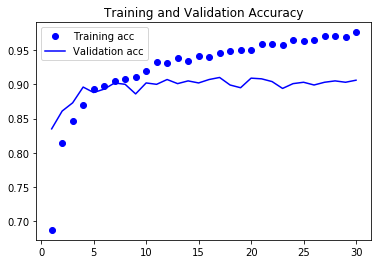

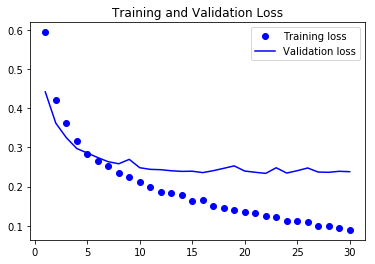

In [9]:
# Plot the results
import matplotlib.pyplot as plt

acc=history.history['acc']
val_acc=history.history['val_acc']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(1,len(acc)+1)

plt.plot(epochs,acc,'bo',label='Training acc')
plt.plot(epochs,val_acc,'b',label='Validation acc')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.figure()
plt.plot(epochs,loss,'bo',label='Training loss')
plt.plot(epochs,val_loss,'b',label='Validation loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [10]:
# Add a densely-connected classifier on top of the convolutional base (only run on GPU)
model=models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 257       
Total params: 16,812,353
Trainable params: 16,812,353
Non-trainable params: 0
_________________________________________________________________


In [11]:
# Freeze the convolutional base
print('This is the number of trainable weights before freezing the conv_base:',len(model.trainable_weights))
conv_base.trainable=False
print('This is the number of trainable weights after freezing the conv_base:',len(model.trainable_weights))

This is the number of trainable weights before freezing the conv_base: 30
This is the number of trainable weights after freezing the conv_base: 4


In [ ]:
# Train the model end-to-end with a frozen convolutional base
from keras.preprocessing.image import ImageDataGenerator

train_datagen=ImageDataGenerator(rescale=1./255, rotation=40,
                                width_shift_range=0.2, height_shift_range=0.2,
                                shear_range=0.2, zoom_range=0.2, 
                                horizontal_flip=True, fill_mode='nearest')
test_datagen=ImageDataGenerator(rescale=1./255)

train_generator=train_datagen.flow_from_directory(train_dir, target_size=(150,150), batch_size=20, class_mode='binary')
validation_generator=test_datagen.flow_from_directory(validation_dir, target_size=(150,150), batch_size=20, class_mode='binary')

model.compile(loss='binary_crossentropy', optimizer=optimizers.RMSprop(lr=2e-5))
history=model.fit_generator(train_generator, steps_per_epoch=100, epochs=30, validation_data=validation_generator, validation_steps=50)

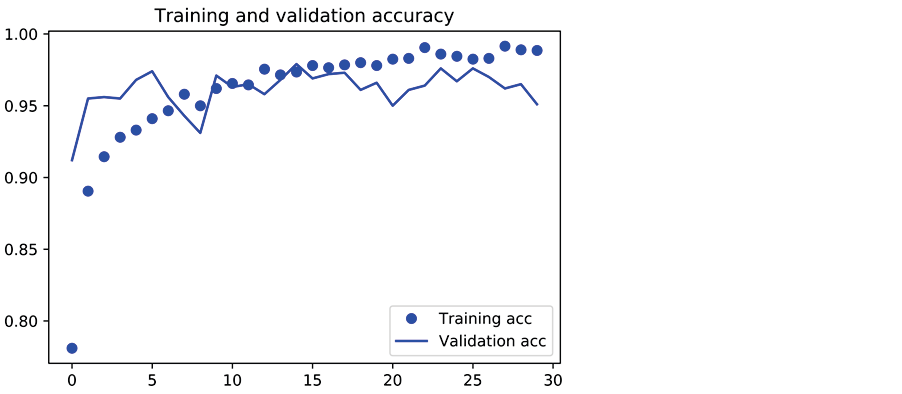

In [ ]:
# Fine-tuning 
# Steps for fine-tuning:
# 1. add your custom network on top of an already trained base network
# 2. freeze the base network
# 3. train the part you added
# 4. unfreeze some layers in the base network
# 5. jointly train both these layers and the part you added

conv_base.trainable=True
set_trainable=False
for layer in conv_base.layers:
    if layer.name=='block5_conv1':
        set_trainable=True
    if set_trainable:
        layer.trainable=True
    else:
        layer.trainable=False

model.compile(loss='binary_crossentropy', optimizer=optimizers.RMSprop(lr=1e-5), metrics=['acc'])
history=model.fit_generator(train_generator, steps_per_epoch=100, epochs=100, validation_data=validation_generator, validation_steps=50)

In [ ]:
# Evaluate the model on the test data
test_generator=test_datagen.flow_from_directory(test_dir, target_size=(150,150), batch_size=20, class_mode='binary')

test_loss, test_acc=model.evaluate_generator(test_generator, steps=50)
print('test acc:', test_acc)